# Employee Attrition Prediction Model

The model uses Employee Attrition dataset from Kaggle's and compares the effectiveness between using Logistic Regression, Neural Network, and Random Forest. We start by analyzing the dataset, keeping the significant ones and removing the uncorrelated ones to optimize performance from our models. Then we proceed to parsing, splitting, and normalizing before training our models. Below are explanations to our work and our code.

In [33]:
import pandas as pd

## Data Parsing

We start with all the data given from the dataset. The raw dataset has 1470 rows and 35 features including Attrition, which is our desired output feature. In terms of data types, there are 26 numerical features and 9 categorical features, ranging from 2 to 6 categories each.

The Parse function below takes in a .CSV file, and does the following things:
1. drop the constant features (columns_to_drop_1)
2. drop the redundant features (columns_to_drop_2)
3. split into input and output features
4. One-hot encode the categorical columns
5. Map the 'Attrition' feature into boolean values

In [34]:
def parse_csv(file_path):
    """
    Parses the CSV file, normalizes numerical data, and one-hot encodes categorical variables.

    Parameters:
    - file_path: str, path to the CSV file.

    Returns:
    - X_processed: pandas DataFrame, processed feature data.
    - y_encoded: pandas Series, encoded target variable.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Dropping constant and redundant features
    columns_to_drop_1 = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
    columns_to_drop_2 = ['MonthlyIncome', 'TotalWorkingYears', 'YearsInCurrentRole', 'YearsWithCurrManager']
    df = df.drop(columns=columns_to_drop_1)
    df = df.drop(columns=columns_to_drop_2)

    # Separate features and target variable
    X = df.drop('Attrition', axis=1)
    y = df['Attrition']

    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # One-hot encode categorical variables
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    # Doesn't normalize. Leave normalization until after splitting training, validation, and test sets.
    
    # Encode the target variable
    y_encoded = y.map({'Yes': 1, 'No': 0})

    return X_encoded, y_encoded

Note that the data isn't normalized when parsing. We leave normalization of data to after we split the data into training, validation, and testing sets. This ensures that there are no data leakages, and provides a better evaluation of our models' performance.

## Simple logistic regression

**Prelminaries**

1. Load the data
2. OHE & Extract test data
3. Normalize the training data

**Simple logistic regression**

4. Train simple logistic regression
5. Evaluate the models with cross-validation

**Regularization**

6. LASSO regularized logistic regression
7. Choose the best model
8. Evaluate the final model with test data

**Conclusion**

9. Compare and Contrast resulting accuracies


### 1. Load and Inspect the data

We can see that all of the data is in numerical form or boolean object which we will one hot encode later.

In [35]:
import pandas as pd
data = pd.read_csv("EmployeeAttritionAllData.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


#### Data Cleaning

We want to check if any row of data is missing value or have repeating values for whole column

In [36]:
# Check for missing data
missing_values = data.isnull().sum()

# Check for constant data
no_unique_values = data.nunique()

missing_values, no_unique_values

(Age                         0
 Attrition                   0
 BusinessTravel              0
 DailyRate                   0
 Department                  0
 DistanceFromHome            0
 Education                   0
 EducationField              0
 EmployeeCount               0
 EmployeeNumber              0
 EnvironmentSatisfaction     0
 Gender                      0
 HourlyRate                  0
 JobInvolvement              0
 JobLevel                    0
 JobRole                     0
 JobSatisfaction             0
 MaritalStatus               0
 MonthlyIncome               0
 MonthlyRate                 0
 NumCompaniesWorked          0
 Over18                      0
 OverTime                    0
 PercentSalaryHike           0
 PerformanceRating           0
 RelationshipSatisfaction    0
 StandardHours               0
 StockOptionLevel            0
 TotalWorkingYears           0
 TrainingTimesLastYear       0
 WorkLifeBalance             0
 YearsAtCompany              0
 YearsIn

While there is no missing values found, 3 columns ('EmployeeCount', 'Over18', 'StandardHours') were found to have constant values for all 1470 rows. Also, 'EmployeeNumber' is a unique identifier for all 1470 rows. These 4 columns should be dropped because they will not help our model.

In [37]:
columns_to_drop = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
data = data.drop(columns=columns_to_drop) 

### 2. OHE & Extract test data

One hot encode categorical data into binary numerical data and then split testing and training data. Making sure to train/test split before normalization so there is no data leakage problems.

In [45]:
from sklearn.model_selection import train_test_split

categorical_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True) #drop_first avoid redundency

X = data.drop(['Attrition_Yes'], axis=1) #Attrition converted to Yes from OHE
y = data['Attrition_Yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Normalize the training data

Next we will standardize the data. The algorithm is technically the same with normalized and un-normalized data. However it can have beneficial effects on the convergence of the optimization solver later. Also we normalize using x-train and then use the same parameter to normalize x-test to ensure no data leakage.


In [46]:
from sklearn.discriminant_analysis import StandardScaler

scaler = StandardScaler()
numerical_columns = X_train.select_dtypes(include=['int64']).columns            ### Only normalize numerical values
no_norm_X_train = X_train
no_norm_x_test = X_test
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns]) 
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

### 4. Train simple logistic regression

Next we train the simple logistic regression model for all features. 

In [47]:
from sklearn.linear_model import LogisticRegression

simple_norm_model = LogisticRegression(solver='liblinear', random_state=42)
simple_norm_model.fit(X_train, y_train)
simple_yhat = simple_norm_model.predict_proba(X_test)[:, 1]

simple_nonorm_model = LogisticRegression(solver='liblinear', random_state=42)
simple_nonorm_model.fit(X_train, y_train)
simple_yhat = simple_norm_model.predict_proba(X_test)[:, 1]

### 5. Evaluate the models with cross-validation

In [48]:
import numpy as np
from sklearn.model_selection import cross_val_score

acc_norm = np.mean(cross_val_score(simple_norm_model, X_train, y_train, scoring='accuracy', cv=3))
print(acc_norm)

0.8664965986394558


### 6. LASSO regularized logistic regression

Regularization is a method for avoiding overfitting by penalizing the complexity of the model in the training process. LASSO regularization in particular penalizes the sum of the absolute values of the parameters. It has the property that it will tend to "zero out" coefficients as the penalty increases. This gives it an additional role as a feature selection technique. 

In [49]:
from sklearn.pipeline import Pipeline


C = np.logspace(-2,1,20)
acc = np.empty(40)
models = list()

for c in range(len(C)):   
    
    model = Pipeline([('scaler', StandardScaler()), 
                 ('logreg', LogisticRegression(C=C[c],
                   penalty='l1',
                   solver='liblinear',
                   random_state=42))])
    model.fit(X_train,y_train)
    
    models.append(model)

    # Validation accuracy
    acc[c] = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()

### 7. Choose the best model

Next we select the model with the best validation accuracy. Outputs the C choosen for Lasso and its accuracy. Also shows which coefficients are zeroed out by Lasso Regulaization.

In [50]:
# Find best model
cstar = np.argmax(acc)
print(f"best Lasso model index: {cstar}")
# Find best model's accuracy
acc_star = acc[cstar]
print(f"best Lasso model accuracy: {acc_star}")

theta = np.vstack([model.named_steps['logreg'].coef_[0,:] for model in models])
theta_star = theta[cstar,:]
print(f"Regularized weights: {theta_star}")
lasso_model = models[cstar]

best Lasso model index: 9
best Lasso model accuracy: 0.8673469387755102
Regularized weights: [-0.20464268 -0.07886658  0.25871296  0.02668742 -0.33167318  0.
 -0.29778319 -0.0735796  -0.35741591  0.          0.04171907  0.40216277
 -0.03771129  0.         -0.10976051 -0.15667816 -0.30719847 -0.15099005
 -0.19916796  0.25049461 -0.43713852  0.40733645 -0.25148231  0.47352194
  0.20384311 -0.35293731  0.          0.          0.05656251  0.
  0.          0.22024027  0.15451363  0.08059917  0.44711811  0.
  0.         -0.14596389  0.10046552  0.          0.22664666  0.06892916
  0.45946556  0.85602333]


### 8. Evaluate all model with test data

Use the test dataset to evaluate the accuracy of the selected LASSO model.

In [51]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

#Accuracy for best Lasso model
yhat = lasso_model.predict(X_test)
lasso_test = accuracy_score(y_test, yhat)
print(f"Accuracy for Regularized Model: {lasso_test}")

#Accyracy for Unregularized model
simple_ypred = (simple_yhat > 0.5).astype(int)
accuracy = accuracy_score(y_test, simple_ypred)
print(f"Unregularized Accuracy: {accuracy}")


Accuracy for Regularized Model: 0.891156462585034
Unregularized Accuracy: 0.8843537414965986


### 9. Compare Results


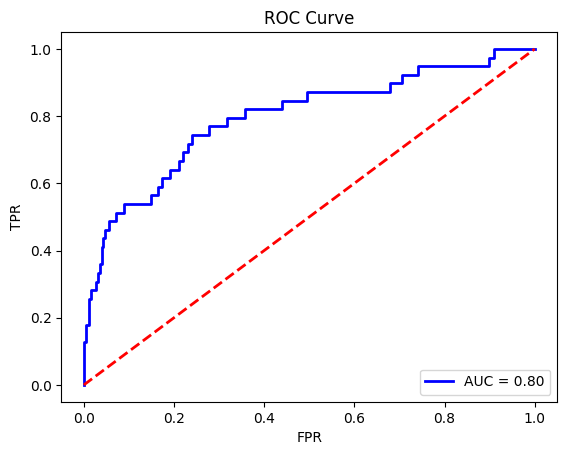

AUC-ROC Score: 0.796480643539467
Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.97      0.94       255
        True       0.67      0.36      0.47        39

    accuracy                           0.89       294
   macro avg       0.79      0.67      0.70       294
weighted avg       0.88      0.89      0.88       294



In [53]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, roc_curve


fpr, tpr, th = roc_curve(y_test, simple_yhat) 
auc = roc_auc_score(y_test, simple_yhat)

lw = 2
plt.plot(fpr, tpr, color='blue', lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--') 
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("AUC-ROC Score:", auc)

#Classification Report
print("Classification Report:")
print(classification_report(y_test, yhat))